In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import numpy as np
sys.path.append('..')

from singleVis.SingleVisualizationModel import VisModel

from singleVis.data import NormalDataProvider

from singleVis.projector import DVIProjector
from singleVis.eval.evaluator import Evaluator

VIS_METHOD = "DVI" # DeepVisualInsight

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################
CONTENT_PATH = "/home/yifan/0ExpMinist/Default/01"

sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

# record output information
# now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
# sys.stdout = open(os.path.join(CONTENT_PATH, now+".txt"), "w")

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]



# VIS_MODEL_NAME = 'dvi_grid'

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)


# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)    

########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################

from singleVis.visualizer import visualizer

vis = visualizer(data_provider, projector, 200, "tab10")
save_dir = os.path.join(data_provider.content_path, "imgptDVI")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-27 22:50:13.447908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 22:50:13.990656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-27 22:50:13.990704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

Finish initialization...


Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 300/300 [00:00<00:00, 7107.74it/s]


Successfully load the DVI visualization model for iteration 20


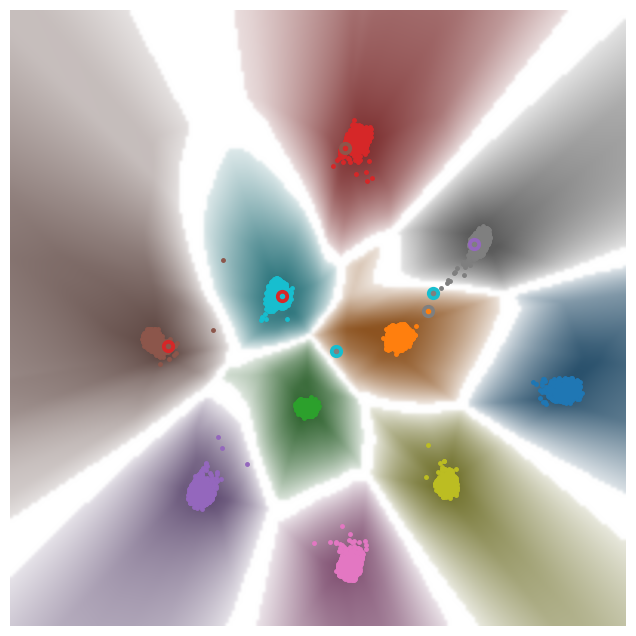

In [2]:
epoch = 20
border = data_provider.border_representation(epoch)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


In [4]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 512))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [47]:
# vae = VAE(512, 256, 20)  # Example dimensions
# Train the VAE here...
i_epoch = 20
from torch import optim
train_data = data_provider.train_representation(i_epoch)

data_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
vae = VAE(512, 256, 2).to(data_provider.DEVICE)  # Example dimensions
optimizer = optim.Adam(vae.parameters())
# Function to compute the VAE loss

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 512), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae.train()

num_epochs = 20  # Example

for epoch in range(num_epochs):
    for i, data in enumerate(data_loader):

        data = data.to(data_provider.DEVICE)
        optimizer.zero_grad()

        recon_batch, mu, logvar = vae(data)
        
        loss = vae_loss(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {loss.item()}')
# # To generate new samples:
# with torch.no_grad():
#     z = torch.randn(64, 20)  # 64 new samples, 20-dimensional latent space
#     samples = vae.decode(z)


Epoch 0, Loss: -1369.0274658203125
Epoch 1, Loss: -1574.003173828125
Epoch 2, Loss: -1399.047119140625
Epoch 3, Loss: -1709.48193359375
Epoch 4, Loss: -1154.6575927734375
Epoch 5, Loss: -1206.22412109375
Epoch 6, Loss: -1680.3734130859375
Epoch 7, Loss: -1341.7166748046875
Epoch 8, Loss: -1806.3447265625
Epoch 9, Loss: -925.6588745117188
Epoch 10, Loss: -1436.75439453125
Epoch 11, Loss: -584.36767578125
Epoch 12, Loss: -1216.3358154296875
Epoch 13, Loss: -2089.728515625
Epoch 14, Loss: -691.2445068359375
Epoch 15, Loss: -1712.4814453125
Epoch 16, Loss: -1753.9345703125
Epoch 17, Loss: -1972.491455078125
Epoch 18, Loss: -1655.77783203125
Epoch 19, Loss: -1692.30078125


In [48]:
with torch.no_grad():
    mu, _ = vae.encode(torch.Tensor(train_data).to(data_provider.DEVICE))
    mu = mu.cpu().numpy()  # Convert to numpy array for easier manipulation

ebd_min = np.min(mu, axis=0)
ebd_max = np.max(mu, axis=0)
ebd_extent = ebd_max - ebd_min
x_min, y_min = ebd_min - 0.02 * ebd_extent
x_max, y_max = ebd_max + 0.02 * ebd_extent
x_min = min(x_min, y_min)
y_min = min(x_min, y_min)
x_max = max(x_max, y_max)
y_max = max(x_max, y_max)

# Xmin, Ymin = mu.min(axis=0)  # Minimum values for each dimension
# Xmax, Ymax = mu.max(axis=0)  # Maximum values for each dimension

In [49]:
x_min, y_min,  x_max, y_max

(-2.20246, -2.20246, 2.2812479, 2.2812479)

In [50]:
import numpy as np
import torch

num_points =100  # for example
x_values = np.linspace(x_min, x_max, num_points)
y_values = np.linspace(y_min, y_max, num_points)
x_grid, y_grid = np.meshgrid(x_values, y_values)
z_grid = np.column_stack([x_grid.flat, y_grid.flat])  # Make a 2D array of shape (num_points**2, 2)



with torch.no_grad():
    z = torch.tensor(z_grid).to(data_provider.DEVICE).float()
    samples = vae.decode(z)


In [39]:
# # To generate new samples:
# with torch.no_grad():
#     z = torch.randn(20000, 2).to(data_provider.DEVICE) # 64 new samples, 20-dimensional latent space
#     samples = vae.decode(z)

In [51]:
samples.shape

torch.Size([10000, 512])

In [42]:
high_d = samples.cpu().numpy()

In [52]:
np.save(os.path.join(data_provider.content_path, "Model", "Epoch_{}".format(20),"GAN.npy"), high_d)

Successfully load the DVI visualization model for iteration 20


100%|██████████| 50/50 [00:00<00:00, 11963.90it/s]

Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20


Successfully load the DVI visualization model for iteration 20


100%|██████████| 50/50 [00:00<00:00, 7560.03it/s]


Successfully load the DVI visualization model for iteration 20


100%|██████████| 50/50 [00:00<00:00, 10428.40it/s]


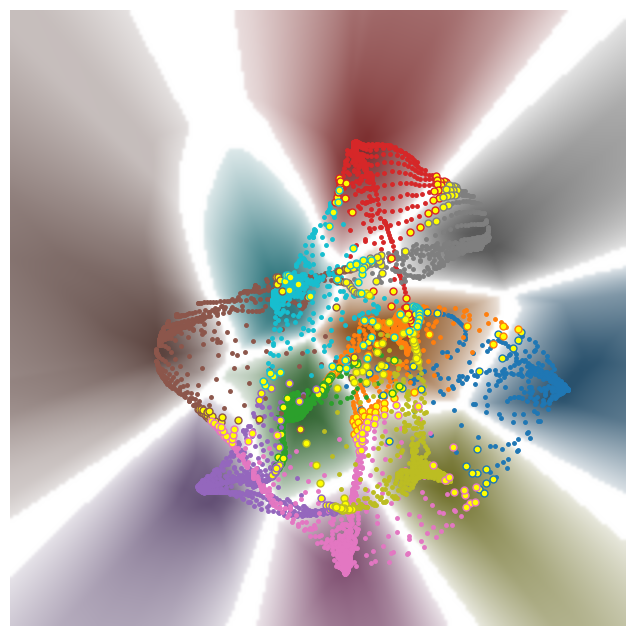

In [46]:
epoch = 20
from singleVis.visualizer_hlb_ import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
# interpolated_X = np.load(os.path.join(data_provider.content_path, "Model", "Epoch_{}".format(epoch),"interpolated_X.npy"))
high_d = samples.cpu().numpy()
emb_new = projector.batch_project(epoch, high_d)
# border = np.zeros(len(interpolated_X))

mesh_preds = data_provider.get_pred(epoch, high_d) + 1e-8

sort_preds = np.sort(mesh_preds, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
border = np.zeros(len(diff), dtype=np.uint8) + 0.05
border[diff < 0.15] = 1


vis.show_grid_embedding(epoch=epoch, data=high_d, border=border,embedding=emb_new, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 20


100%|██████████| 200/200 [00:00<00:00, 9563.37it/s]

Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20



100%|██████████| 200/200 [00:00<00:00, 9799.43it/s]


Successfully load the DVI visualization model for iteration 20


100%|██████████| 200/200 [00:00<00:00, 9741.73it/s]


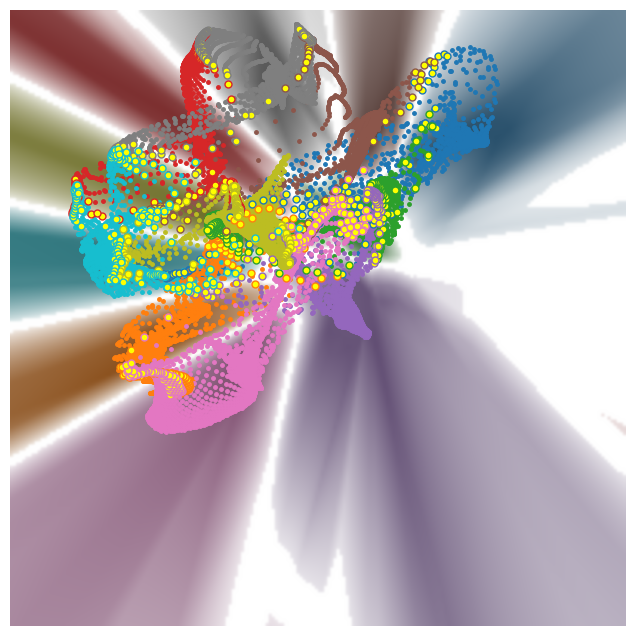

In [25]:
epoch = 20
from singleVis.visualizer_hlb_ import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
# interpolated_X = np.load(os.path.join(data_provider.content_path, "Model", "Epoch_{}".format(epoch),"interpolated_X.npy"))
high_d = samples.cpu().numpy()
emb_new = projector.batch_project(epoch, high_d)
# border = np.zeros(len(interpolated_X))

mesh_preds = data_provider.get_pred(epoch, high_d) + 1e-8

sort_preds = np.sort(mesh_preds, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
border = np.zeros(len(diff), dtype=np.uint8) + 0.05
border[diff < 0.15] = 1


vis.show_grid_embedding(epoch=epoch, data=high_d, border=border,embedding=emb_new, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [4]:
def interpolate_samples(sample1, sample2, num_interpolations):
    t_values = np.linspace(0, 1, num_interpolations+2)[1:-1] # 去掉0和1，保证生成的样本不包括原始样本
    interpolated_samples = np.empty((num_interpolations, sample1.shape[0]))

    for i, t in enumerate(t_values):
        interpolated_samples[i] = t * sample1 + (1 - t) * sample2
        
    return interpolated_samples

In [4]:
num_pairs = 20000
num_interpolations_per_pair = 2  # 每一对样本生成2个插值样本，这样总共就会生成40000个插值样本
X = data_provider.train_representation(epoch)
interpolated_X = np.empty((num_pairs * num_interpolations_per_pair, 512))
for i in range(num_pairs):
    sample1 = X[np.random.randint(0, X.shape[0])]
    sample2 = X[np.random.randint(0, X.shape[0])]
    interpolated_samples = interpolate_samples(sample1, sample2, num_interpolations_per_pair)
    interpolated_X[i*num_interpolations_per_pair : (i+1)*num_interpolations_per_pair] = interpolated_samples

In [5]:
interpolated_X.shape

(40000, 512)

In [8]:
epoch = 20

In [5]:
interpolated_X = np.load(os.path.join(data_provider.content_path, "Model", "Epoch_{}".format(epoch),"interpolated_X.npy"))

In [7]:
def interpolate_samples(sample1, sample2, t):
    return t * sample1 + (1 - t) * sample2

def select_samples_from_different_classes(X, labels):
    classes = np.unique(labels)
    selected_samples = []
    for i in range(len(classes)-1):
        for j in range(i+1, len(classes)):
            samples_class_i = X[labels == classes[i]]
            samples_class_j = X[labels == classes[j]]
            sample1 = samples_class_i[np.random.choice(samples_class_i.shape[0])]
            sample2 = samples_class_j[np.random.choice(samples_class_j.shape[0])]
            selected_samples.append((sample1, sample2))
    return selected_samples

In [15]:
X = data_provider.train_representation(epoch)
labels = data_provider.train_labels(epoch)
from scipy.special import softmax
def get_conf(epoch, interpolated_X):
        predctions = data_provider.get_pred(epoch, interpolated_X)
        scores = np.amax(softmax(predctions, axis=1), axis=1)
        return scores

def generate_interpolated_samples(X, labels, get_conf, num_interpolations_per_bin):
    selected_samples = select_samples_from_different_classes(X, labels)
    
    # confidence_bins = np.linspace(0, 1, 11)[1:-1]  # 置信度区间
    confidence_bins = np.linspace(0.5, 1, 6)[1:-1]  # 置信度区间
   

    
    interpolated_X = {bin: [] for bin in confidence_bins}  # 储存插值样本的字典，键是置信度区间，值是插值样本

    print("interpolated_X",interpolated_X)
    # 执行循环，直到每个置信度区间都有足够的插值样本
    while min([len(samples) for samples in interpolated_X.values()]) < num_interpolations_per_bin:
        batch_samples = []
        for _ in range(100):
            # 选择两个样本并生成插值样本
            sample1, sample2 = selected_samples[np.random.choice(len(selected_samples))]
            t = np.random.rand()  # 随机选择插值参数t
            interpolated_sample = interpolate_samples(sample1, sample2, t)
            batch_samples.append(interpolated_sample)

        # 计算插值样本的置信度并根据置信度将其分配到相应的区间
        print("batch_samples",len(batch_samples))
        confidences = get_conf(epoch, np.array(batch_samples))
        for i, confidence in enumerate(confidences):
            for bin in confidence_bins:
                if confidence < bin:
                    interpolated_X[bin].append(batch_samples[i])
                    print("interpolated_X",len(interpolated_X[0.6]),len(interpolated_X[0.7]))
                    break

    return interpolated_X

In [ ]:
interpolated_X_div = generate_interpolated_samples(X,labels,get_conf,20000)

In [32]:
confidence_bins = np.linspace(0.5, 1, 6)[1:-1]  # 置信度区间
interpolated_samples = np.concatenate([np.array(interpolated_X_div[bin]) for bin in confidence_bins])


In [33]:
interpolated_samples.shape

(116193, 512)

Successfully load the DVI visualization model for iteration 20


100%|██████████| 30/30 [00:00<00:00, 12762.87it/s]

Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20



100%|██████████| 30/30 [00:00<00:00, 13210.41it/s]

Successfully load the DVI visualization model for iteration 20



100%|██████████| 30/30 [00:00<00:00, 13243.78it/s]


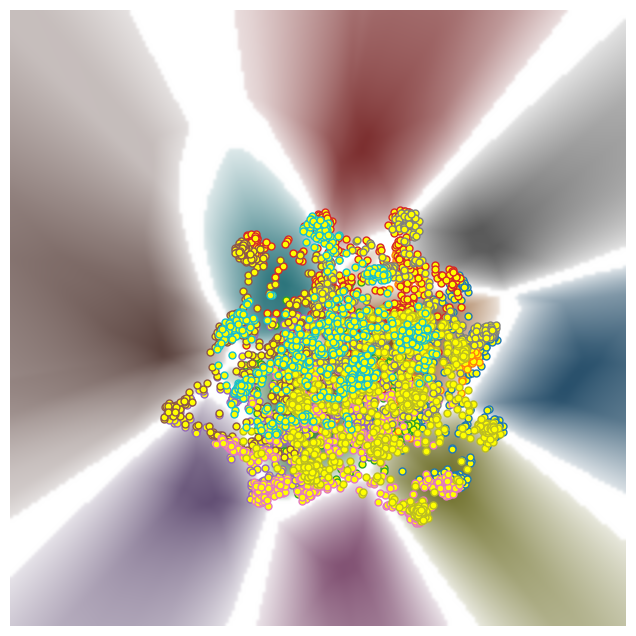

In [6]:
from singleVis.visualizer_hlb_ import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
interpolated_X = np.load(os.path.join(data_provider.content_path, "Model", "Epoch_{}".format(epoch),"interpolated_X.npy"))
high_d = data_provider.border_representation(epoch)
emb_new = projector.batch_project(epoch, high_d)
# border = np.zeros(len(interpolated_X))

mesh_preds = data_provider.get_pred(epoch, high_d) + 1e-8

sort_preds = np.sort(mesh_preds, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
border = np.zeros(len(diff), dtype=np.uint8) + 0.05
border[diff < 0.15] = 1


vis.show_grid_embedding(epoch=epoch, data=high_d, border=border,embedding=emb_new, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 20


100%|██████████| 30/30 [00:00<00:00, 12781.02it/s]


Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 30/30 [00:00<00:00, 13735.30it/s]


Successfully load the DVI visualization model for iteration 20


100%|██████████| 30/30 [00:00<00:00, 13391.78it/s]


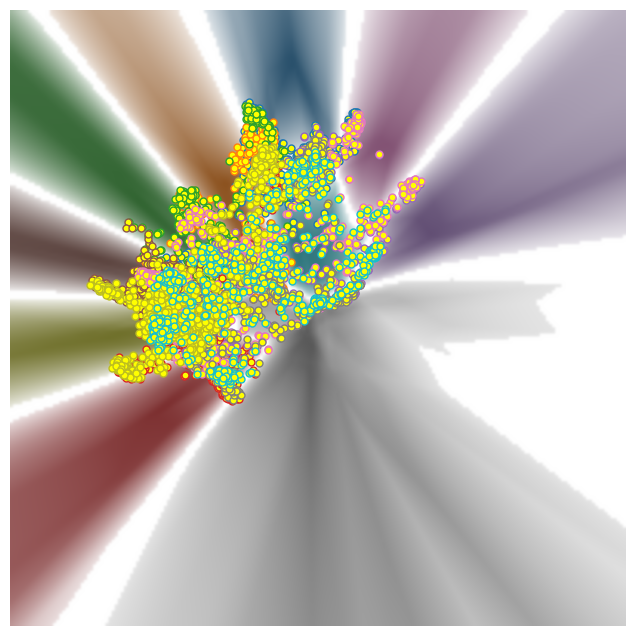

In [50]:
from singleVis.visualizer_hlb_ import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
interpolated_X = np.load(os.path.join(data_provider.content_path, "Model", "Epoch_{}".format(epoch),"interpolated_X.npy"))
high_d = data_provider.border_representation(epoch)
emb_new = projector.batch_project(epoch, high_d)
# border = np.zeros(len(interpolated_X))

mesh_preds = data_provider.get_pred(epoch, high_d) + 1e-8

sort_preds = np.sort(mesh_preds, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
border = np.zeros(len(diff), dtype=np.uint8) + 0.05
border[diff < 0.15] = 1


vis.show_grid_embedding(epoch=epoch, data=high_d, border=border,embedding=emb_new, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 20


100%|██████████| 149/149 [00:00<00:00, 10172.40it/s]

Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20


Successfully load the DVI visualization model for iteration 20


100%|██████████| 149/149 [00:00<00:00, 11112.02it/s]

Successfully load the DVI visualization model for iteration 20



100%|██████████| 149/149 [00:00<00:00, 11122.11it/s]


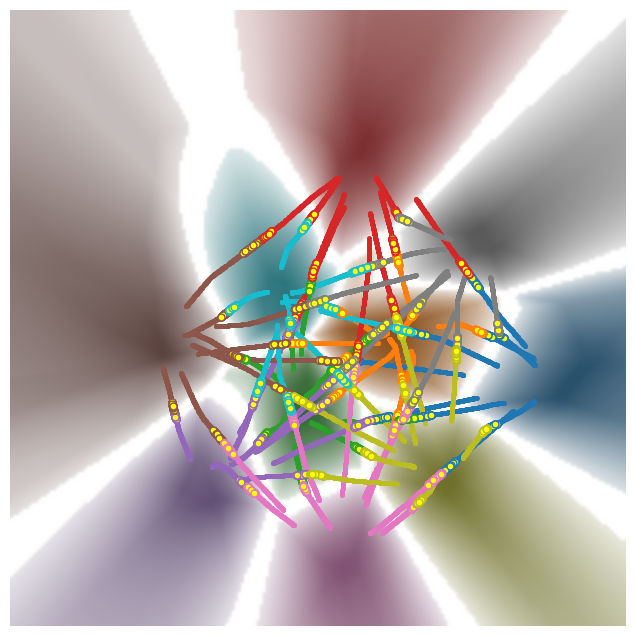

In [7]:
from singleVis.visualizer_hlb_ import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
interpolated_X = np.load(os.path.join(data_provider.content_path, "Model", "Epoch_{}".format(epoch),"interpolated_X.npy"))
high_d = interpolated_X
emb_new = projector.batch_project(epoch, high_d)
# border = np.zeros(len(interpolated_X))

mesh_preds = data_provider.get_pred(epoch, high_d) + 1e-8

sort_preds = np.sort(mesh_preds, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
border = np.zeros(len(diff), dtype=np.uint8) + 0.05
border[diff < 0.15] = 1


vis.show_grid_embedding(epoch=epoch, data=high_d, border=border,embedding=emb_new, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 20


100%|██████████| 58/58 [00:00<00:00, 13505.23it/s]

Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20



100%|██████████| 58/58 [00:00<00:00, 13542.82it/s]

Successfully load the DVI visualization model for iteration 20



100%|██████████| 58/58 [00:00<00:00, 13669.14it/s]


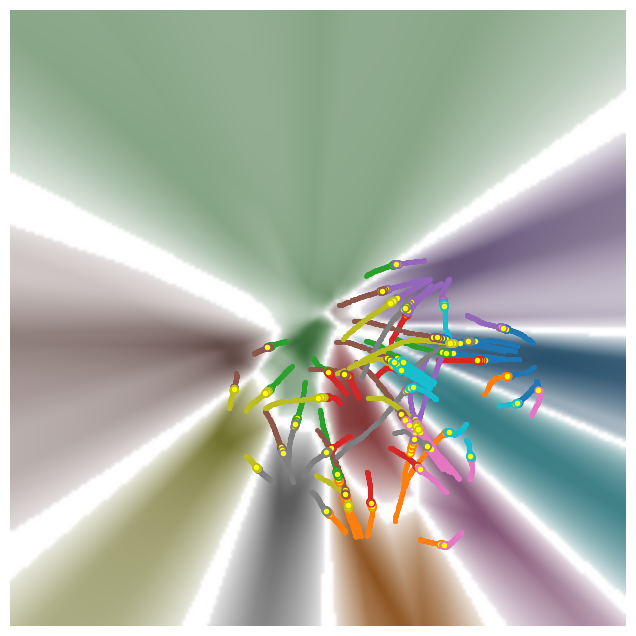

In [11]:
from singleVis.visualizer_hlb_ import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
interpolated_X = np.load(os.path.join(data_provider.content_path, "Model", "Epoch_{}".format(epoch),"interpolated_X.npy"))
high_d = interpolated_X

emb_new = projector.batch_project(epoch, high_d)
# border = np.zeros(len(interpolated_X))

mesh_preds = data_provider.get_pred(epoch, high_d) + 1e-8

sort_preds = np.sort(mesh_preds, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
border = np.zeros(len(diff), dtype=np.uint8) + 0.05
border[diff < 0.1] = 1


vis.show_grid_embedding(epoch=epoch, data=high_d, border=border,embedding=emb_new, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [49]:
num_interpolations_per_bin = 20000  # 每个区间生成2000个插值样本，这样总共就会生成20000个插值样本

selected_samples = select_samples_from_different_classes(X, labels)


In [50]:
confidence_bins = np.linspace(0, 1, 11)[1:-1]  # 置信度区间
interpolated_X = np.empty((len(confidence_bins) * num_interpolations_per_bin, 512))


In [51]:
for i, t in enumerate(confidence_bins):
    for j in range(num_interpolations_per_bin):
        sample1, sample2 = selected_samples[np.random.choice(len(selected_samples))]
        interpolated_X[i*num_interpolations_per_bin + j] = interpolate_samples(sample1, sample2, t)

In [54]:
interpolated_X.shape

(180000, 512)

Successfully load the DVI visualization model for iteration 20


100%|██████████| 200/200 [00:00<00:00, 9387.12it/s]

Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20


Successfully load the DVI visualization model for iteration 20


100%|██████████| 200/200 [00:00<00:00, 9878.60it/s]

Successfully load the DVI visualization model for iteration 20



100%|██████████| 200/200 [00:00<00:00, 9895.14it/s]


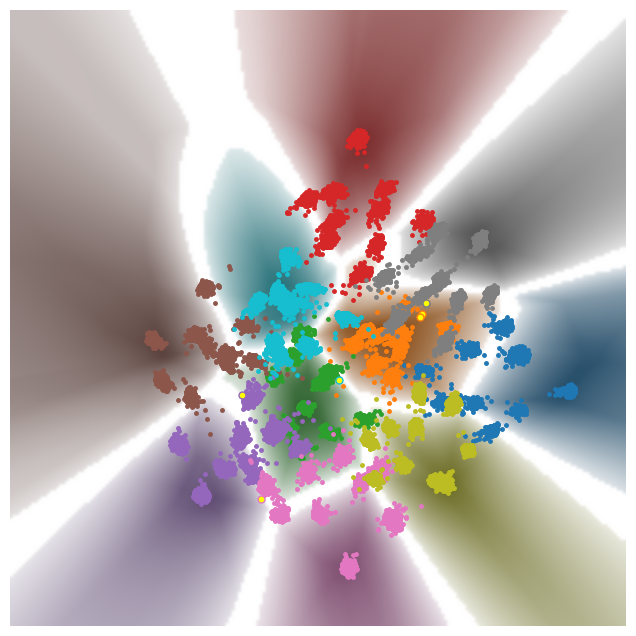

In [59]:
from singleVis.visualizer_hlb_ import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_init', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
emb_new = projector.batch_project(epoch, interpolated_X)
# border = np.zeros(len(interpolated_X))

mesh_preds = data_provider.get_pred(epoch, interpolated_X) + 1e-8

sort_preds = np.sort(mesh_preds, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
border = np.zeros(len(diff), dtype=np.uint8) + 0.05
border[diff < 0.15] = 1


vis.show_grid_embedding(epoch=epoch, data=interpolated_X, border=border,embedding=emb_new, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 20


100%|██████████| 200/200 [00:00<00:00, 9948.89it/s]

Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20



100%|██████████| 200/200 [00:00<00:00, 9954.09it/s]

Successfully load the DVI visualization model for iteration 20



100%|██████████| 200/200 [00:00<00:00, 9927.46it/s]


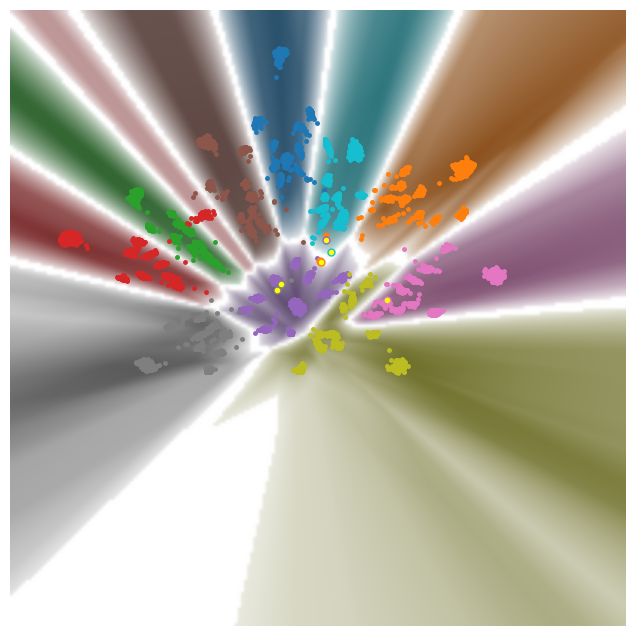

In [58]:
from singleVis.visualizer_hlb_ import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)  
vis = visualizer(data_provider, projector, 200, "tab10")
emb_new = projector.batch_project(epoch, interpolated_X)
# border = np.zeros(len(interpolated_X))

mesh_preds = data_provider.get_pred(epoch, interpolated_X) + 1e-8

sort_preds = np.sort(mesh_preds, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
border = np.zeros(len(diff), dtype=np.uint8) + 0.05
border[diff < 0.15] = 1


vis.show_grid_embedding(epoch=epoch, data=interpolated_X, border=border,embedding=emb_new, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 11/11 [00:00<00:00, 6620.37it/s]


Successfully load the DVI visualization model for iteration 20


100%|██████████| 11/11 [00:00<00:00, 4888.98it/s]


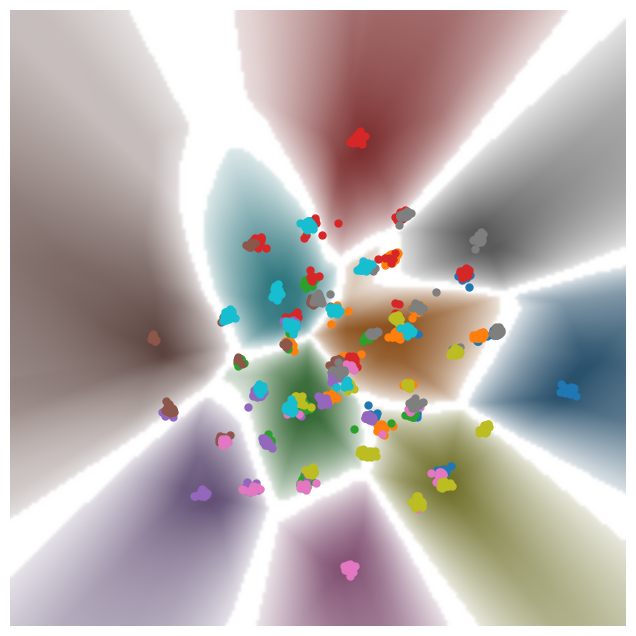

In [41]:
from singleVis.visualizerbigger import visualizer

vis = visualizer(data_provider, projector, 200, "tab10")
newdata = np.concatenate((interpolated_X, [sample1,sample2]),axis=0)
emb_new = projector.batch_project(epoch, newdata)
border = np.zeros(len(newdata))

vis.show_grid_embedding(epoch=epoch, data=newdata, border=border,embedding=emb_new, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 1/1 [00:00<00:00, 3865.72it/s]


Successfully load the DVI visualization model for iteration 20


100%|██████████| 1/1 [00:00<00:00, 2798.07it/s]


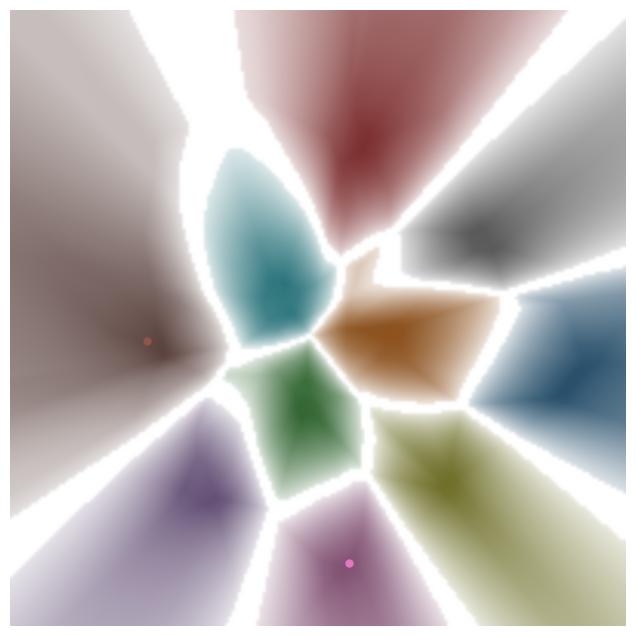

In [37]:
newdata = np.array([sample1,sample2])
emb_new = projector.batch_project(epoch, newdata)
border = np.zeros(len(newdata))

vis.show_grid_embedding(epoch=epoch, data=newdata, border=border,embedding=emb_new, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
"""get high dimensional grid, 2d grid embedding and border vector"""

grid_high, grid_emd ,border = vis.get_epoch_decision_view(epoch,200,None, True)
train_data_embedding = projector.batch_project(epoch, data_provider.train_representation(epoch))
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 假设 train_data_embedding 和 grid_emd 都是 numpy arrays，每一行都是一个点
threshold = 1 # 设置你的阈值

# 使用 train_data_embedding 初始化 NearestNeighbors 对象
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train_data_embedding)
# 对于 grid_emd 中的每一个点，找到 train_data_embedding 中离它最近的点
distances, indices = nbrs.kneighbors(grid_emd)
# 找到距离小于阈值的索引
mask = distances.ravel() < threshold
selected_indices = np.arange(grid_emd.shape[0])[mask]

border_indices = np.arange(grid_emd.shape[0])[border==1]
union_indices = np.union1d(selected_indices, border_indices)

In [ ]:
vis.show_grid_embedding(epoch=epoch, data=grid_high, border=border,embedding=grid_emd, noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
import numpy as np

def sample_line(x0, y0, x1, y1, num_samples):
    dx = x1 - x0
    dy = y1 - y0
    step_x = dx / num_samples
    step_y = dy / num_samples

    line_indices = []

    for i in range(num_samples+1):
        x = x0 + i * step_x
        y = y0 + i * step_y
        line_indices.append((int(x), int(y)))

    return line_indices
num_samples = 200 
line_indices = sample_line(grid_emd[0][0], grid_emd[0][1], grid_emd[300][0], grid_emd[300][1],num_samples)

In [ ]:
line_indices

In [ ]:
show_list = union_indices
vis.show_grid_embedding(epoch=epoch, data=grid_high[[show_list]], border=border[[show_list]],embedding=grid_emd[show_list], noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
show_list = union_indices
vis.show_grid_embedding(epoch=epoch, data=grid_high[[show_list]], border=border[[show_list]],embedding=grid_emd[show_list], noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
show_list =  union_indices
emb_new = projector.batch_project(epoch, grid_high)
vis.show_grid_embedding(epoch=epoch, data=grid_high[[show_list]], border=border[[show_list]],embedding=emb_new[show_list], noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
projector2 = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE)   
vis2 = visualizer(data_provider, projector2, 200, "tab10")
grid_high2, grid_emd2 ,border = vis2.get_epoch_decision_view(epoch,200,None, True)

emb_new2 = projector2.batch_project(epoch, grid_high2)
vis.show_grid_embedding(epoch=epoch, data=grid_high2[[border_indices]], border=border[[border_indices]],embedding=emb_new2[border_indices], noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))


In [ ]:
emb_new = projector.batch_project(epoch, grid_high)
vis.show_grid_embedding(epoch=epoch, data=grid_high[[border_indices]], border=border[[border_indices]],embedding=emb_new[border_indices], noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
grid_high.shape

In [ ]:
emb_new.shape

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
def calError(grid_high, emb_new):
    k = 5  # 最近邻的数量
    nn_orig = NearestNeighbors(n_neighbors=k+1).fit(grid_high)
    nn_reduced = NearestNeighbors(n_neighbors=k+1).fit(emb_new)
    dist_orig, _ = nn_orig.kneighbors(grid_high, n_neighbors=k+1)
    dist_reduced, _ = nn_reduced.kneighbors(emb_new, n_neighbors=k+1)

    # 计算流形保持误差
    manifold_error = np.mean((dist_orig[:, 1:] - dist_reduced[:, 1:])**2)

    print("Manifold Preservation Error:", manifold_error)



In [ ]:
calError(grid_high,emb_new)

In [ ]:
calError(grid_high2,emb_new2)

In [ ]:
calError(grid_high,emb_new2)

In [ ]:
"""Add grid into train
"""

from singleVis.SingleVisualizationModel import VisModel
from singleVis.spatial_edge_constructor import SingleEpochSpatialEdgeConstructorForGrid

pre_model = VisModel(ENCODER_DIMS, DECODER_DIMS)
file_path = os.path.join(CONTENT_PATH, "Model", "Epoch_{}".format(epoch), "{}.pth".format('dvi'))
save_model = torch.load(file_path, map_location="cpu")
pre_model.load_state_dict(save_model["state_dict"])
pre_model.to(DEVICE)


In [ ]:
grid_high, grid_emd ,border = vis.get_epoch_decision_view(epoch,200,None, True)

In [ ]:
import time
train_list =  union_indices
# train_list =  border_indices
optimizer = torch.optim.Adam(pre_model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
# Define Edge dataset
t0 = time.time()
###### all grid + training 
# N_NEIGHBORS = 30
spatial_cons = SingleEpochSpatialEdgeConstructorForGrid(data_provider, grid_high[train_list], epoch, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS,only_grid=True)
###### only grid 
# spatial_cons = SingleEpochSpatialEdgeConstructorForGrid(data_provider, grid_high[union_indices], epoch, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS,only_grid=True)
edge_to, edge_from, probs, feature_vectors, attention = spatial_cons.construct()
t1 = time.time()
from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, TemporalLoss, DVILoss, SingleVisLoss, DummyTemporalLoss
from singleVis.edge_dataset import DVIDataHandler
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
probs = probs / (probs.max()+1e-3)
eliminate_zeros = probs>5e-2    #1e-3
edge_to = edge_to[eliminate_zeros]
edge_from = edge_from[eliminate_zeros]
probs = probs[eliminate_zeros]
dataset = DVIDataHandler(edge_to, edge_from, feature_vectors, attention)

n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(probs, n_samples, replacement=True)
edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)
from umap.umap_ import find_ab_params
temporal_loss_fn = DummyTemporalLoss(DEVICE)
# LAMBDA1 = 3
# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
single_loss_fn = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA1)
criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=LAMBDA1, lambd2=0.0,device=DEVICE)

In [ ]:

from singleVis.trainer import SingleVisTrainer
from tqdm import tqdm
from singleVis.losses import PositionRecoverLoss

def disable_grad(model):
    for param in model.parameters():
        param.requires_grad = False   
        
class DVIReFineTrainer(SingleVisTrainer):
    def __init__(self, model, criterion, optimizer, lr_scheduler, edge_loader, DEVICE, grid, disable_encoder_grad=False, **kwargs):
        super().__init__(model, criterion, optimizer, lr_scheduler, edge_loader, DEVICE, **kwargs)
        self.disable_encoder_grad = disable_encoder_grad
        self.grid = grid

    
    def train_step(self):
        
        self.model = self.model.to(device=self.DEVICE)
        ####### disable encoder
        if self.disable_encoder_grad == True:
            print("dis")
            disable_grad(self.model.encoder)

        self.model.train()
        all_loss = []
        umap_losses = []
        recon_losses = []
        temporal_losses = []
        recoverposition_losses = []
        # loss_fn = PositionRecoverLoss()

        t = tqdm(self.edge_loader, leave=True, total=len(self.edge_loader))
        
        for data in t:
            edge_to, edge_from, a_to, a_from = data

            edge_to = edge_to.to(device=self.DEVICE, dtype=torch.float32)
            edge_from = edge_from.to(device=self.DEVICE, dtype=torch.float32)
            a_to = a_to.to(device=self.DEVICE, dtype=torch.float32)
            a_from = a_from.to(device=self.DEVICE, dtype=torch.float32)

            outputs = self.model(edge_to, edge_from)
            umap_l, recon_l, temporal_l, loss = self.criterion(edge_to, edge_from, a_to, a_from, self.model, outputs)

            grid_high = self.model.decoder(torch.Tensor(self.grid).to(self.DEVICE))
            new_emb = self.model.encoder(grid_high).to(self.DEVICE)

            pos_recover_loss_fn = PositionRecoverLoss(self.DEVICE)

            pos_loss = pos_recover_loss_fn(torch.Tensor(self.grid).to(self.DEVICE), torch.Tensor(new_emb))

            all_loss.append(loss.mean().item())
            umap_losses.append(umap_l.item())
            recon_losses.append(recon_l.item())
            temporal_losses.append(temporal_l.mean().item())
            recoverposition_losses.append(pos_loss.mean().item())
            # ===================backward====================
            recoverposition_loss = sum(recoverposition_losses) / len(recoverposition_losses)
            loss_new = loss + 1 * recoverposition_loss
            self.optimizer.zero_grad()
            loss_new.mean().backward()
            # pos_loss.mean().backward()
            self.optimizer.step()
        self._loss = sum(all_loss) / len(all_loss)
        self.model.eval()
        print('umap:{:.4f}\trecon_l:{:.4f}\ttemporal_l:{:.4f}\tloss:{:.4f}\tecoverposition_losses:{}'.format(sum(umap_losses) / len(umap_losses),
                                                                sum(recon_losses) / len(recon_losses),
                                                                sum(temporal_losses) / len(temporal_losses),
                                                                sum(all_loss) / len(all_loss), sum(recoverposition_losses) / len(all_loss)))
        return self.loss
    
    def record_time(self, save_dir, file_name, operation, iteration, t):
        # save result
        save_file = os.path.join(save_dir, file_name+".json")
        if not os.path.exists(save_file):
            evaluation = dict()
        else:
            f = open(save_file, "r")
            evaluation = json.load(f)
            f.close()
        if operation not in evaluation.keys():
            evaluation[operation] = dict()
        evaluation[operation][iteration] = round(t, 3)
        with open(save_file, 'w') as f:
            json.dump(evaluation, f)

In [ ]:
# from singleVis.trainer import DVIReFineTrainer
trainer = DVIReFineTrainer(pre_model, criterion, optimizer, lr_scheduler, edge_loader, DEVICE, grid_emd[union_indices], disable_encoder_grad = True)

t2=time.time()
trainer.train(PATIENT, MAX_EPOCH)
t3 = time.time()

    # save result
save_dir = data_provider.model_path
trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "complex_construction", str(epoch), t1-t0)
trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "training", str(epoch), t3-t2)
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(epoch))
trainer.save(save_dir=save_dir, file_name="{}".format('dvi_grid'))

print("Finish epoch {}...".format(epoch))

In [ ]:
# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE)    
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))

In [ ]:
# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE)    
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))

In [ ]:

from singleVis.visualizer_hlb_ import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE)   

vis2 = visualizer(data_provider, projector, 200, "tab10")
vis2.savefig(epoch, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid2')),th=0.25)

In [ ]:

from singleVis.visualizer_hlb_ import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE)   

vis2 = visualizer(data_provider, projector, 200, "tab10")
vis2.savefig(epoch, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid2')), th=0.25)

In [ ]:

from singleVis.visualizer_hl_b import visualizer
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE)   

vis2 = visualizer(data_provider, projector, 200, "tab10")
vis2.savefig(epoch, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid2')))

In [ ]:
"""get high dimensional grid, 2d grid embedding and border vector"""

grid_high, grid_emd ,border = vis.get_epoch_decision_view(epoch,200,None, True)
train_data_embedding = projector.batch_project(epoch, data_provider.train_representation(epoch))

In [ ]:
border_indices = np.arange(grid_emd.shape[0])[border==1]
show_list = border_indices
vis.show_grid_embedding(epoch=epoch, data=grid_high[[show_list]], border=border[[show_list]],embedding=grid_emd[show_list], noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
border_indices = np.arange(grid_emd.shape[0])[border==1]
show_list = border_indices
vis.show_grid_embedding(epoch=epoch, data=grid_high[[show_list]], border=border[[show_list]],embedding=grid_emd[show_list], noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
emb_new = projector.batch_project(epoch, grid_high)
vis.show_grid_embedding(epoch=epoch, data=grid_high[[border_indices]], border=border[[border_indices]],embedding=emb_new[border_indices], noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
show_list = union_indices
emb_new = projector.batch_project(epoch, grid_high)
vis.show_grid_embedding(epoch=epoch, data=grid_high[[union_indices]], border=border[[union_indices]],embedding=emb_new[union_indices], noOutline=True, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
"""get high dimensional grid, 2d grid embedding and border vector"""

grid_high, grid_emd ,border = vis.get_epoch_decision_view(epoch,200,None, True)
train_data_embedding = projector.batch_project(epoch, data_provider.train_representation(epoch))
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 假设 train_data_embedding 和 grid_emd 都是 numpy arrays，每一行都是一个点
threshold = 20 # 设置你的阈值

# 使用 train_data_embedding 初始化 NearestNeighbors 对象
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train_data_embedding)
# 对于 grid_emd 中的每一个点，找到 train_data_embedding 中离它最近的点
distances, indices = nbrs.kneighbors(grid_emd)
# 找到距离小于阈值的索引
mask = distances.ravel() < threshold
selected_indices = np.arange(grid_emd.shape[0])[mask]

border_indices = np.arange(grid_emd.shape[0])[border==1]
union_indices = np.union1d(selected_indices, border_indices)

In [ ]:
vis.show_grid_embedding(epoch=epoch, data=grid_high[[selected_indices]], embedding=grid_emd[selected_indices], path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [ ]:
emb_new = projector.batch_project(epoch, grid_high)
vis.show_grid_embedding(epoch=epoch, data=grid_high[[union_indices]], embedding=emb_new[union_indices], path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))